In [ ]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_squared_error

from scipy.stats import spearmanr
import pymannkendall as mk
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from pymannkendall import original_test as mk_test
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor



In [2]:
#load data

data = pd.read_csv("/media/kibria/624309e6-cae1-4eca-a603-4ebc61fc0d9b/data/archive/owid-covid-data.csv")

In [3]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [4]:

# Filter Bangladesh data

bd_data = data[data['location'] == 'Bangladesh'].copy()
bd_data['date'] = pd.to_datetime(bd_data['date'])

In [ ]:
# data shape and columns

print(f"Data shape: {bd_data.shape}")


# Check for missing values
print(bd_data.isnull().sum())

Data shape: (1386, 67)
iso_code                                      0
continent                                     0
location                                      0
date                                          0
total_cases                                  66
                                           ... 
population                                    0
excess_mortality_cumulative_absolute       1386
excess_mortality_cumulative                1386
excess_mortality                           1386
excess_mortality_cumulative_per_million    1386
Length: 67, dtype: int64


In [6]:
# statistics discribe of new caeses

print(bd_data['new_cases'].describe())

count     1385.000000
mean      1477.142960
std       2687.038805
min          0.000000
25%         23.000000
50%        350.000000
75%       1733.000000
max      16230.000000
Name: new_cases, dtype: float64


In [ ]:
# statistics discribe of new death

print(bd_data['new_deaths'].describe())

count    1384.000000
mean       21.302746
std        42.631263
min         0.000000
25%         0.000000
50%         3.000000
75%        27.000000
max       264.000000
Name: new_deaths, dtype: float64


In [8]:
# Number of days with zero cases

zero_cases = (bd_data['new_cases'] == 0).sum()
print(f"Days with zero new cases: {zero_cases}")

Days with zero new cases: 82


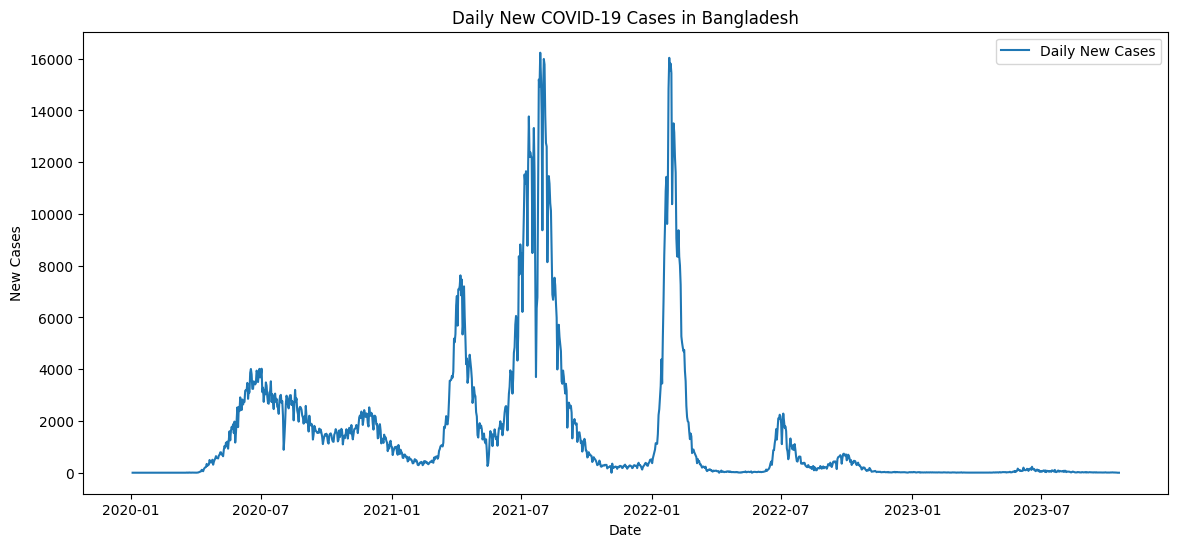

In [9]:
#graph new cases

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='new_cases', data=bd_data, label='Daily New Cases')
plt.title('Daily New COVID-19 Cases in Bangladesh')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.show()


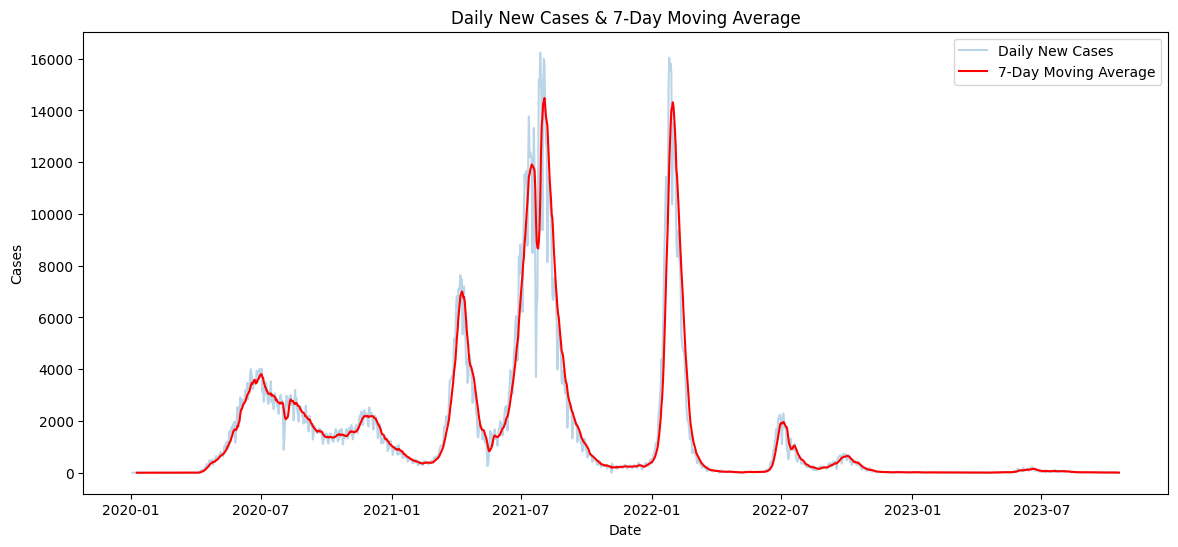

In [10]:
# Daily new cases and 7 days moving average

bd_data['new_cases_ma7'] = bd_data['new_cases'].rolling(window=7).mean()

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='new_cases', data=bd_data, alpha=0.3, label='Daily New Cases')
sns.lineplot(x='date', y='new_cases_ma7', data=bd_data, label='7-Day Moving Average', color='red')
plt.title('Daily New Cases & 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()


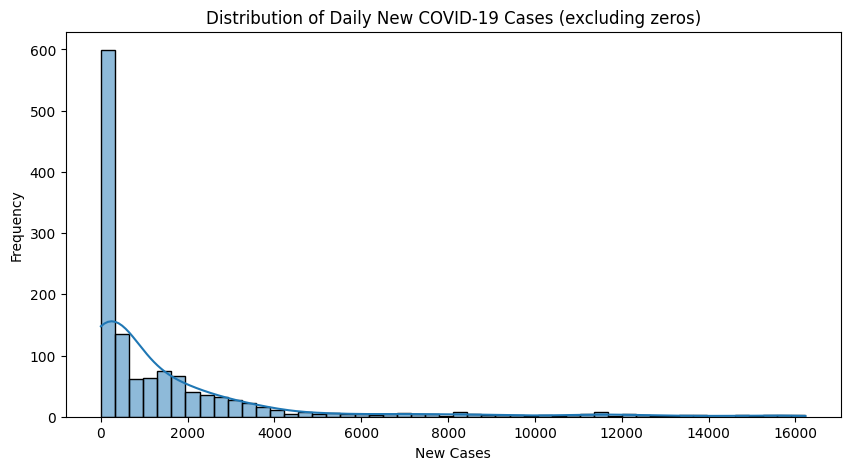

In [11]:
#Distribution of daily new cases
plt.figure(figsize=(10,5))
sns.histplot(bd_data['new_cases'][bd_data['new_cases'] > 0], bins=50, kde=True)
plt.title('Distribution of Daily New COVID-19 Cases (excluding zeros)')
plt.xlabel('New Cases')
plt.ylabel('Frequency')
plt.show()


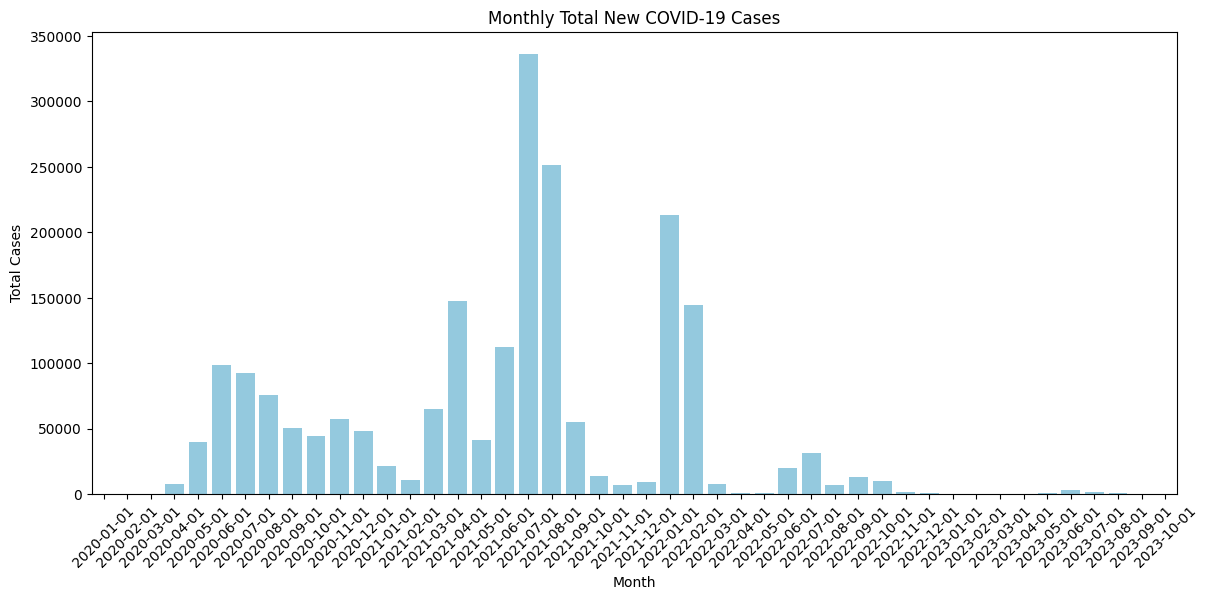

In [12]:
#Monthly total new cases

bd_data['month'] = bd_data['date'].dt.to_period('M')
monthly_cases = bd_data.groupby('month')['new_cases'].sum().reset_index()
monthly_cases['month'] = monthly_cases['month'].dt.to_timestamp()

plt.figure(figsize=(14,6))
sns.barplot(x='month', y='new_cases', data=monthly_cases, color='skyblue')
plt.title('Monthly Total New COVID-19 Cases')
plt.xlabel('Month')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.show()


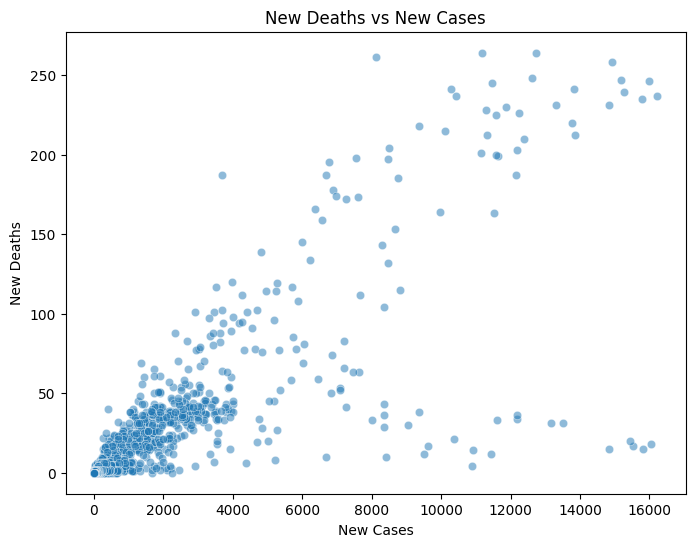

Correlation between new cases and new deaths: 0.810


In [13]:
# new deaths vs new cases
plt.figure(figsize=(8,6))
sns.scatterplot(x='new_cases', y='new_deaths', data=bd_data, alpha=0.5)
plt.title('New Deaths vs New Cases')
plt.xlabel('New Cases')
plt.ylabel('New Deaths')
plt.show()

corr = bd_data[['new_cases', 'new_deaths']].corr().iloc[0,1]
print(f"Correlation between new cases and new deaths: {corr:.3f}")


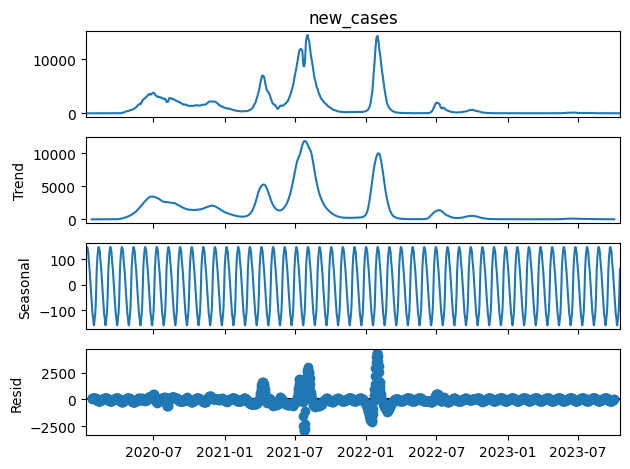

In [14]:
# seasonal decompose new cases
from statsmodels.tsa.seasonal import seasonal_decompose

bd_data_indexed = bd_data.set_index('date')
result = seasonal_decompose(bd_data_indexed['new_cases'].rolling(window=7).mean().dropna(), model='additive', period=30)

result.plot()
plt.show()



The time series plot reveals waves and peaks of COVID-19 cases.

The 7-day moving average smooths daily fluctuations.

Distribution is right-skewed (many days with low cases, few with high spikes).

Monthly aggregation shows clear peaks corresponding to COVID waves.

Positive correlation between new cases and deaths confirms severity trends.

Seasonal decomposition may reveal any recurring weekly/monthly patterns.

In [15]:
# Mann kendall trend test

result = mk.original_test(bd_data['new_cases'].values)
print("Mann-Kendall Trend Test:")
print(f"Trend: {result.trend}")
print(f"p-value: {result.p}")


Mann-Kendall Trend Test:
Trend: decreasing
p-value: 0.0


Interpretation:
This means there is a statistically significant decreasing trend in COVID-19 new cases over the analyzed time period in Bangladesh.

The p-value being effectively zero means we strongly reject the null hypothesis of no trend, confirming that cases have been going down overall.

In [16]:
# Load data


data = pd.read_csv("/media/kibria/624309e6-cae1-4eca-a603-4ebc61fc0d9b/data/archive/owid-covid-data.csv")

bd_data = data[data['location'] == 'Bangladesh'].copy()
bd_data['date'] = pd.to_datetime(bd_data['date'])
bd_data = bd_data[['date', 'new_cases', 'new_deaths']].fillna(0)

# Prepare numeric time variable for trend test
bd_data['day_num'] = (bd_data['date'] - bd_data['date'].min()).dt.days

In [ ]:
# mann kendall trend test

result = mk_test(bd_data['new_cases'].values)
print("Mann-Kendall Trend Test:")
print(f"Trend: {result.trend}")
print(f"p-value: {result.p}")


Mann-Kendall Trend Test:
Trend: decreasing
p-value: 0.0


In [18]:
# spearman correlation

corr, p_value = spearmanr(bd_data['new_cases'], bd_data['new_deaths'])
print(f"Spearman correlation between new cases and new deaths: {corr:.3f}, p-value: {p_value:.4f}")


Spearman correlation between new cases and new deaths: 0.910, p-value: 0.0000


 significant Correlation Between Cases and Deaths

<Figure size 1000x500 with 0 Axes>

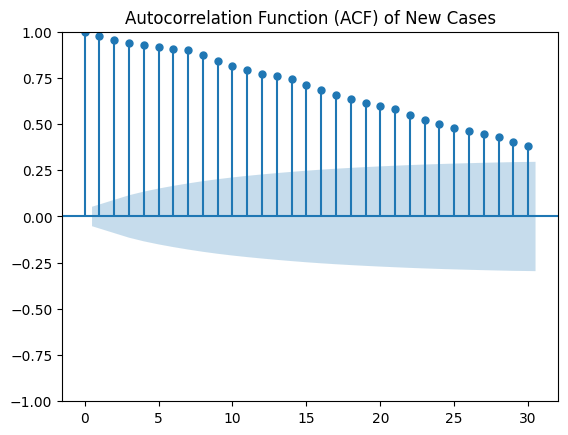

In [19]:
# graph acf plot
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(bd_data['new_cases'], lags=30)
plt.title('Autocorrelation Function (ACF) of New Cases')
plt.show()


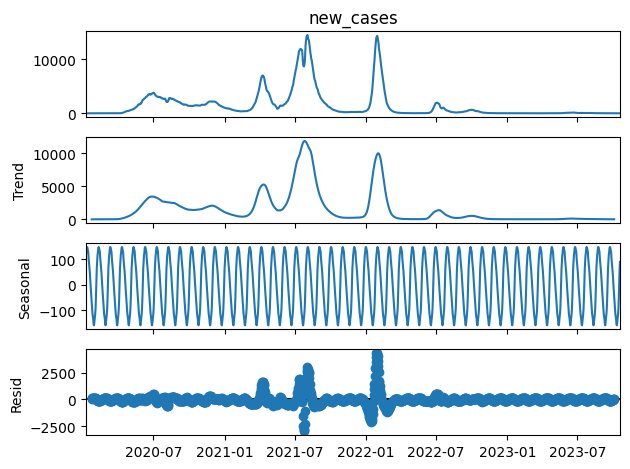

In [20]:
# seasonal decompose
bd_data.set_index('date', inplace=True)
decomposition = seasonal_decompose(bd_data['new_cases'].rolling(7).mean().dropna(), model='additive', period=30)
decomposition.plot()
plt.show()


In [21]:
# Mann-Whitney U test
lockdown_date = pd.to_datetime('2021-07-01')

before = bd_data[bd_data.index < lockdown_date]['new_cases']
after = bd_data[bd_data.index >= lockdown_date]['new_cases']

stat, p = mannwhitneyu(before, after, alternative='two-sided')
print(f"Mann-Whitney U test for cases before and after lockdown:")
print(f"p-value = {p:.4f}")


Mann-Whitney U test for cases before and after lockdown:
p-value = 0.0000


significant difference in median cases before and after lockdown.

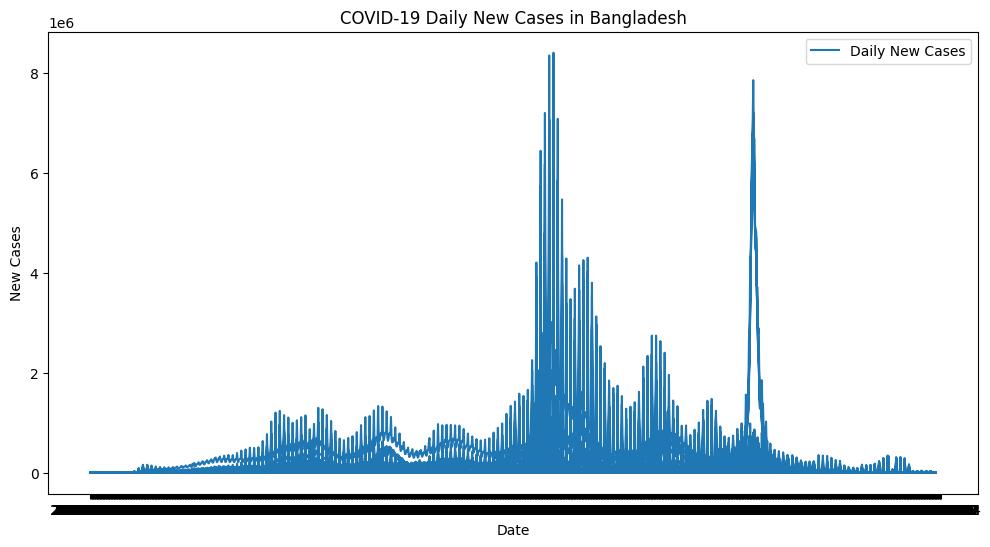

In [22]:

df=data.copy()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['new_cases'], label='Daily New Cases')
plt.title("COVID-19 Daily New Cases in Bangladesh")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.show()


In [23]:
df.shape

(350085, 67)

In [24]:
df.isnull().sum()

iso_code                                        0
continent                                   16665
location                                        0
date                                            0
total_cases                                 37997
                                            ...  
population                                      0
excess_mortality_cumulative_absolute       337901
excess_mortality_cumulative                337901
excess_mortality                           337901
excess_mortality_cumulative_per_million    337901
Length: 67, dtype: int64

In [ ]:

df = df.dropna(subset=['new_cases'])

In [ ]:

df['date'] = pd.to_datetime(df['date'])
df['day_num'] = (df['date'] - df['date'].min()).dt.days


X = df['day_num'].values.reshape(-1,1)
y = df['new_cases'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


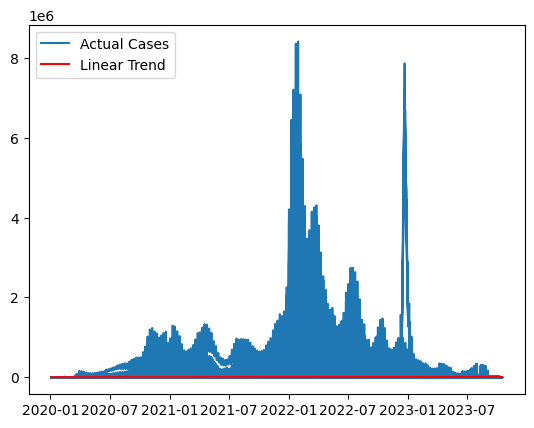

In [27]:
# Predict trend line
df['trend'] = model.predict(X)

plt.plot(df['date'], y, label='Actual Cases')
plt.plot(df['date'], df['trend'], label='Linear Trend', color='red')
plt.legend()
plt.show()


In [ ]:
df_prophet = df.rename(columns={'date':'ds', 'new_cases':'y'})


model = Prophet(daily_seasonality=True)
model.fit(df_prophet)


future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


00:29:18 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing


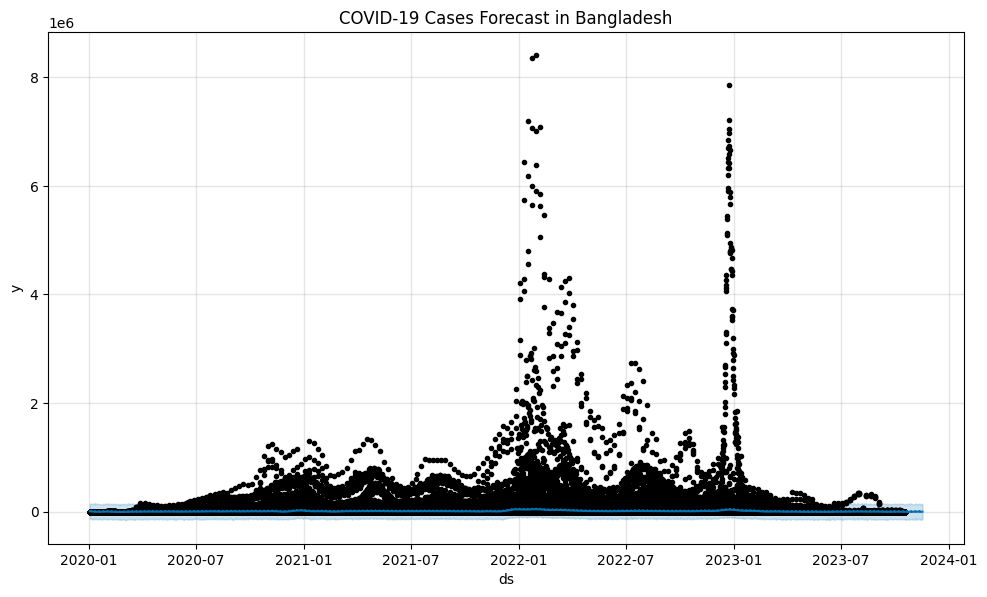

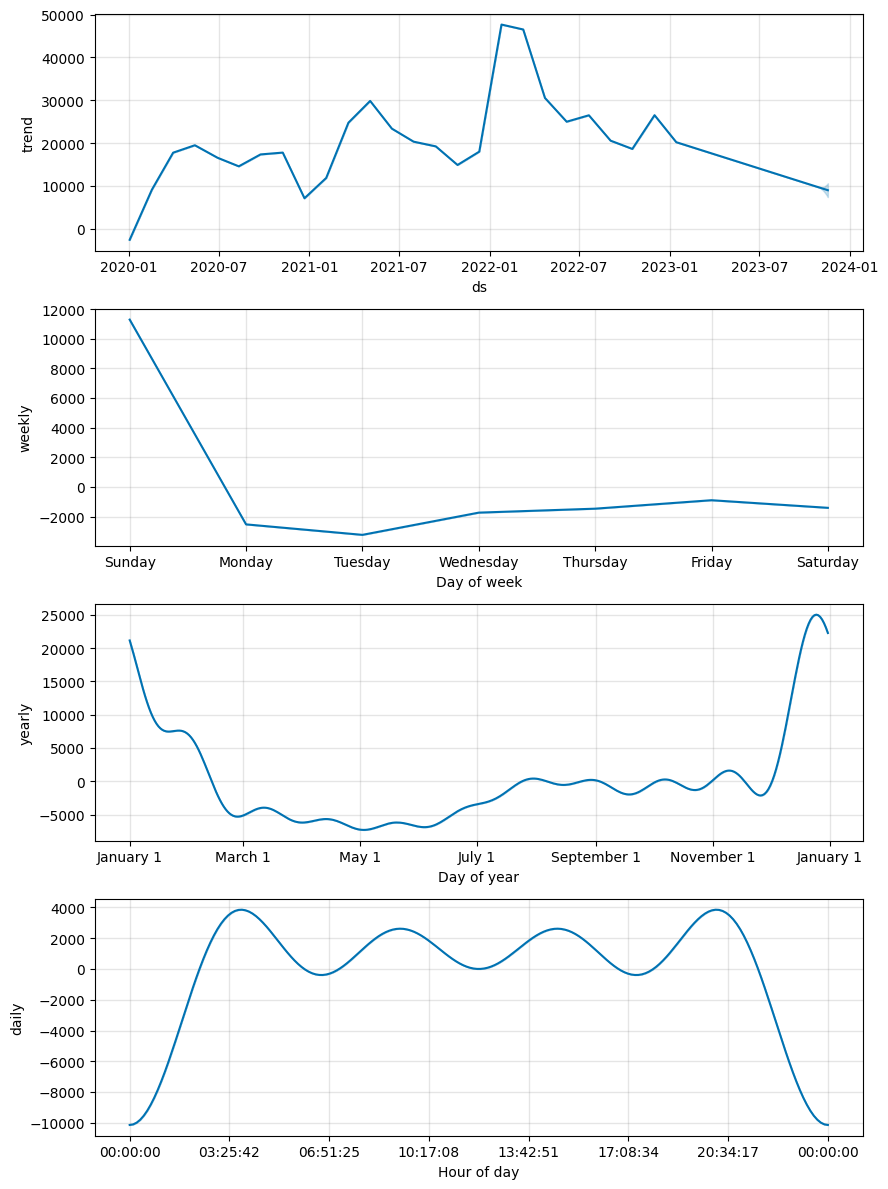

In [29]:
# Plot forecast
model.plot(forecast)
plt.title("COVID-19 Cases Forecast in Bangladesh")
plt.show()

# Plot forecast components
model.plot_components(forecast)
plt.show()

In [30]:
bd_data=df.copy()

split_date = bd_data['date'].max() - pd.Timedelta(days=30)
train_df = bd_data[bd_data['date'] <= split_date]
test_df = bd_data[bd_data['date'] > split_date]


train_prophet = train_df.rename(columns={'date':'ds', 'new_cases':'y'})


model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

# Create future dataframe for the test period
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Extract forecast for test period only
forecast_test = forecast[forecast['ds'] > split_date]

# Merge forecast with actual test data
comparison_df = test_df.merge(forecast_test[['ds', 'yhat']], left_on='date', right_on='ds')


mae = mean_absolute_error(comparison_df['new_cases'], comparison_df['yhat'])
rmse = np.sqrt(mean_squared_error(comparison_df['new_cases'], comparison_df['yhat']))

print(f"MAE on test set: {mae:.2f}")
print(f"RMSE on test set: {rmse:.2f}")




00:30:23 - cmdstanpy - INFO - Chain [1] start processing
00:31:23 - cmdstanpy - INFO - Chain [1] done processing


MAE on test set: 11330.12
RMSE on test set: 12337.11


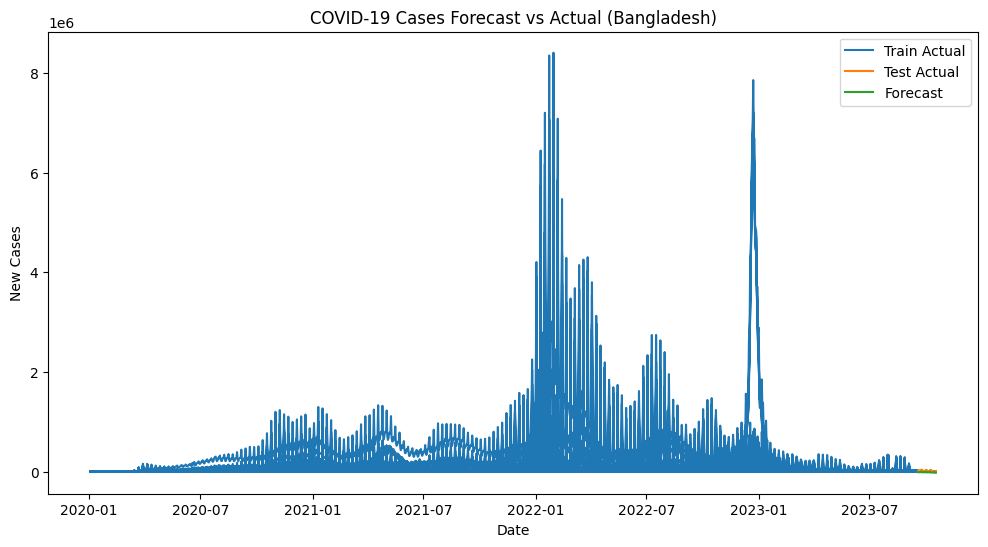

In [31]:
# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(train_df['date'], train_df['new_cases'], label='Train Actual')
plt.plot(test_df['date'], test_df['new_cases'], label='Test Actual')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('COVID-19 Cases Forecast vs Actual (Bangladesh)')
plt.legend()
plt.show()

In [32]:
#use only cpu and not use gpu

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:


dates = pd.date_range(start="2020-01-01", periods=200, freq="D")
new_cases = np.random.randint(0, 500, size=len(dates))
df = pd.DataFrame({"date": dates, "new_cases": new_cases})


df['date'] = pd.to_datetime(df['date'])


df = df.sort_values('date').reset_index(drop=True)

for lag in range(1, 8):
    df[f'lag_{lag}'] = df['new_cases'].shift(lag)


df = df.dropna().reset_index(drop=True)



In [34]:
# feature selection

features = [f'lag_{lag}' for lag in range(1, 8)]
X = df[features]
y = df['new_cases']

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, df['date'], test_size=0.2, random_state=42
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 154
Test samples: 39


In [35]:
# model fit

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 131.07
RMSE: 160.39


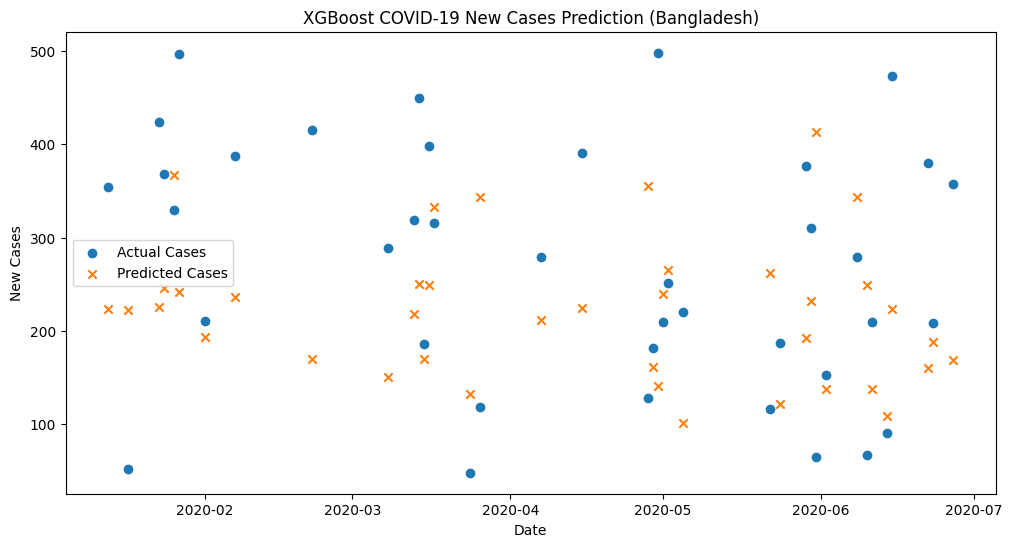

In [36]:
#graph 

plt.figure(figsize=(12,6))
plt.scatter(dates_test, y_test, label='Actual Cases', marker='o')
plt.scatter(dates_test, y_pred, label='Predicted Cases', marker='x')
plt.title('XGBoost COVID-19 New Cases Prediction (Bangladesh)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()
